### Well placement map

In [11]:
import os
import pickle
import argparse

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
################################################
# Need to integrate in parser.py for future work
################################################
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()

args.master_directory = os.getcwd()
args.basicfilepath = 'data'
args.simulation_directory = 'simulation'
args.variable_save_directory = 'variables'
args.deeplearningmodel_save_directory = 'model'
args.ecl_filename = '2D_ECL'
args.perm_filename = 'PERMX'
args.well_filename = 'WELL'

args.learning_rate = 0.001  # Learning rate Alpha
# args.boltzmann_tau_start = 5.0  # Start value of Temperature parameter at Boltzmann policy, Tau
args.boltzmann_tau_start = 8.0  # Start value of Temperature parameter at Boltzmann policy, Tau
args.boltzmann_tau_end = 0.1  # End value of Temperature parameter at Boltzmann policy, Tau
args.boltzmann_tau_tracker = [args.boltzmann_tau_start]
# args.total_reward = 0
args.epsilon = 0.1

# For Implementation # 2023-07-09 (2nd Trial)
# args.max_iteration = 50 # Maximum iteration num. of algorithm, MAX_STEPS
# args.max_iteration = 10  # Maximum iteration num. of algorithm, MAX_STEPS
args.max_iteration = 20  # Maximum iteration num. of algorithm, MAX_STEPS

# args.sample_num_per_iter = 50 # Simulation sample num. of each iteration of algorithm
# args.sample_num_per_iter = 10
args.sample_num_per_iter = 20

# args.experience_num_per_iter = 250 # Experience sample num. of each iteration of algorithm, h
args.experience_num_per_iter = 100  # Experience sample num. of each iteration of algorithm, h
# args.replay_batch_num = 16 # Replay batch num., B
args.replay_batch_num = 32  # Replay batch num., B
args.nn_update_num = 1 # CNN update number, U: [(1) Constant num. of iteration], (2) Lower limit of loss function value
args.batch_size = 32 # Batch size, N
args.replay_memory_size = 1000 # Replay memory size, K

# # For Debugging
# args.max_iteration = 5  # Maximum iteration num. of algorithm, MAX_STEPS
# args.sample_num_per_iter = 3  # Simulation sample num. of each iteration of algorithm
# args.experience_num_per_iter = 15  # Experience sample num. of each iteration of algorithm, h
# args.replay_batch_num = 4  # Replay batch num., B
# args.nn_update_num = 4  # CNN update number, U: [(1) Constant num. of iteration], (2) Lower limit of loss function value
# args.batch_size = 8  # Batch size, N
# args.replay_memory_size = 30  # Replay memory size, K

args.gridnum_x = 15
args.gridnum_y = 15
args.gridsize_x = 120  # ft
args.gridsize_y = 120  # ft

args.time_step = 120  # days
args.total_production_time = 600  # days

args.prod_well_num_max = 5
args.inj_well_num_max = 0
args.total_well_num_max = args.prod_well_num_max + args.inj_well_num_max

args.initial_PRESSURE = 3500  # psi
args.initial_SOIL = 0.75

# 2023-05-02: For reproduction
args.random_seed = 202022673
random.seed(args.random_seed)
np.random.seed(args.random_seed)
torch.manual_seed(args.random_seed)

# For calculation of revenue at each time step
args.oil_price = 60  # $/bbl
args.water_treatment = 3  # $/bbl
args.water_injection = 5  # $/bbl

# State: Pressure distribution, Oil saturation, Well placement map

# Action: Well placement (Coordinate of well location)

# Environment: Reservoir simulator

# Reward: NPV at each time segment

args.discount_rate = 0.1  # Used for calculation of NPV
args.discount_factor = 1  # Used for Q-value update

# Data for State
args.input_flag = ('PRESSURE', 'SOIL', 'Well_placement')

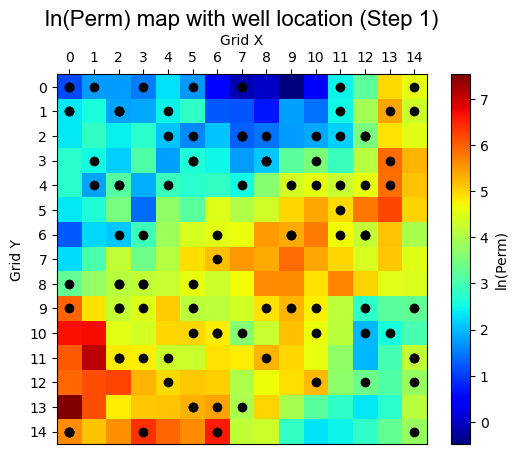

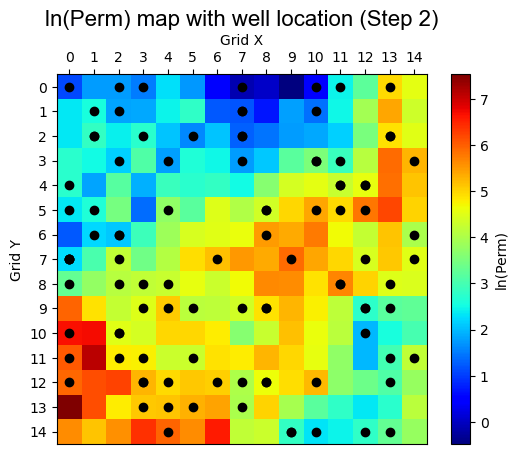

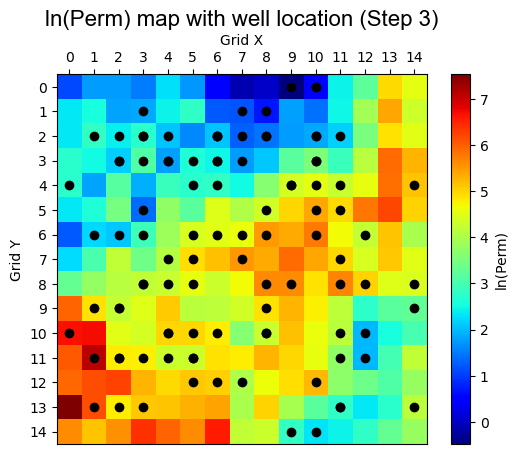

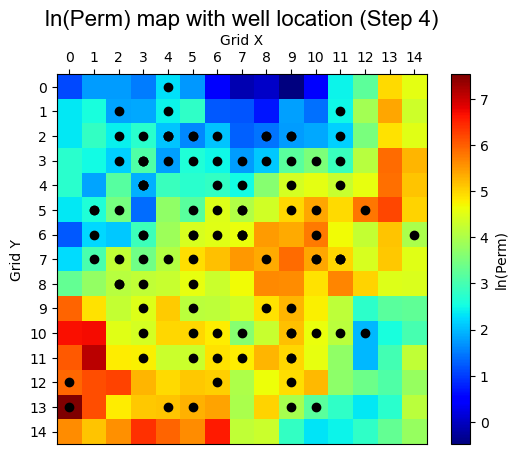

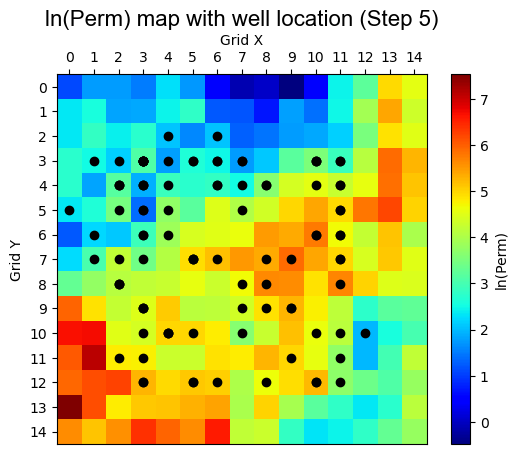

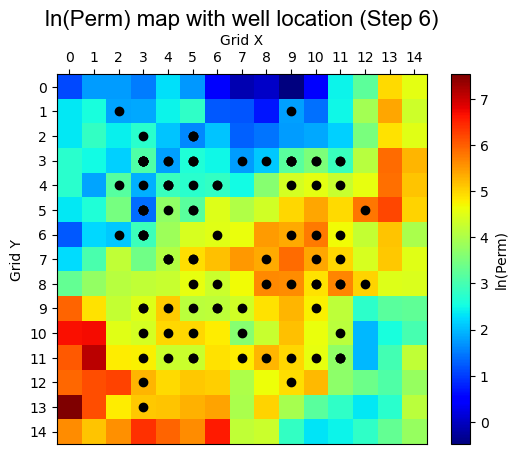

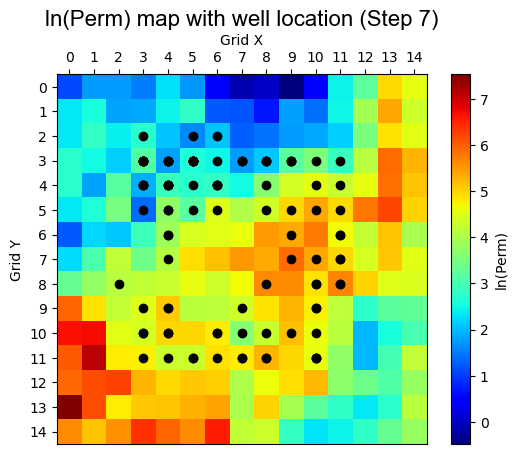

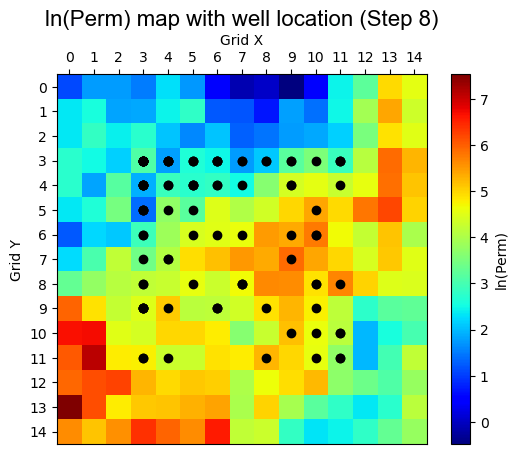

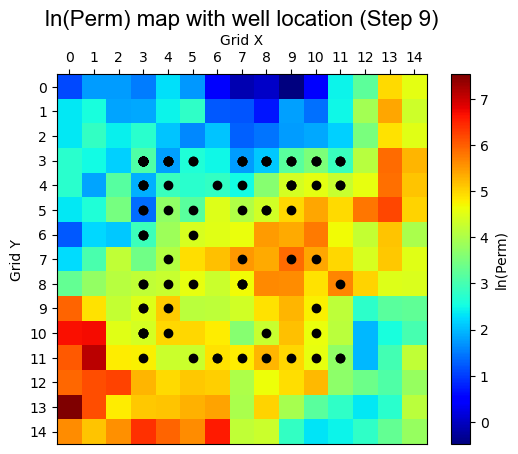

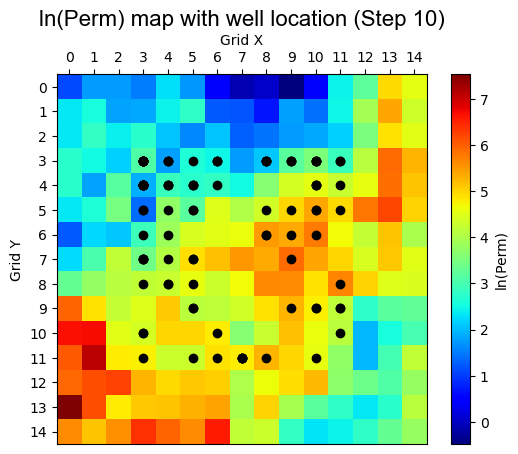

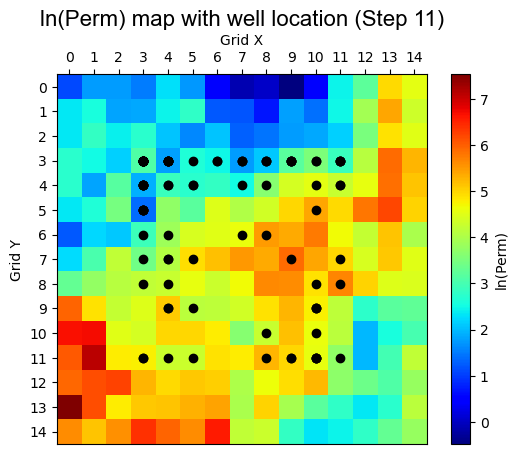

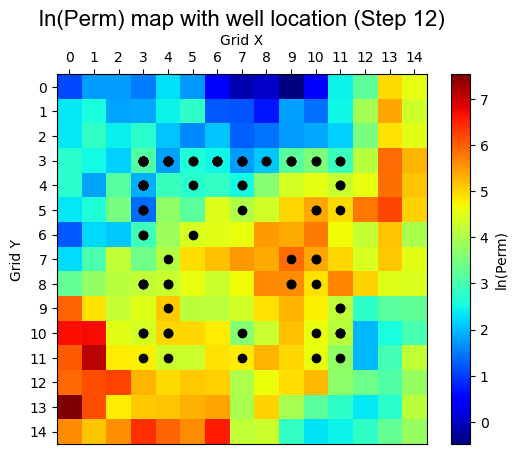

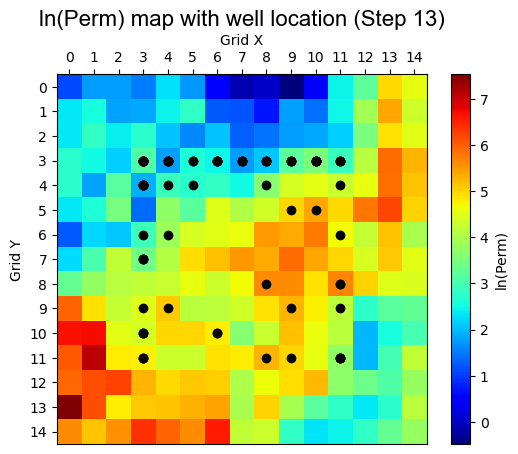

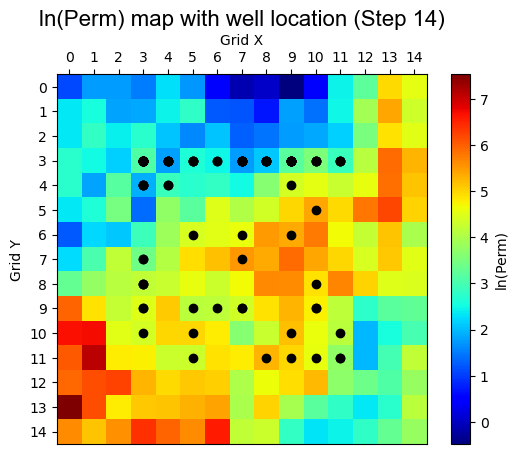

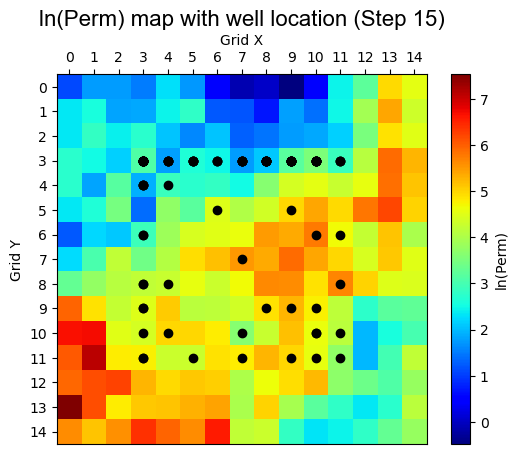

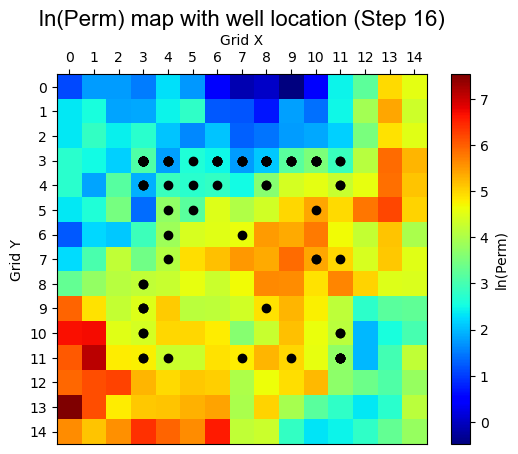

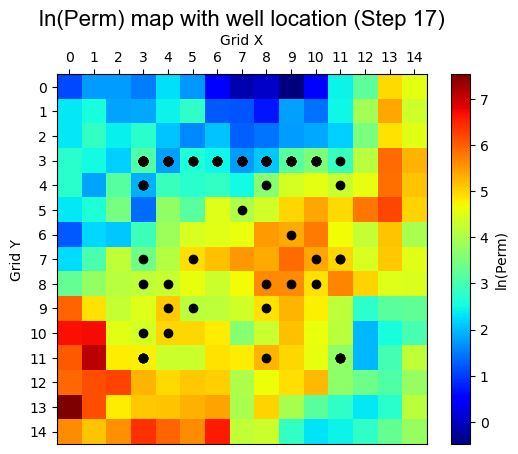

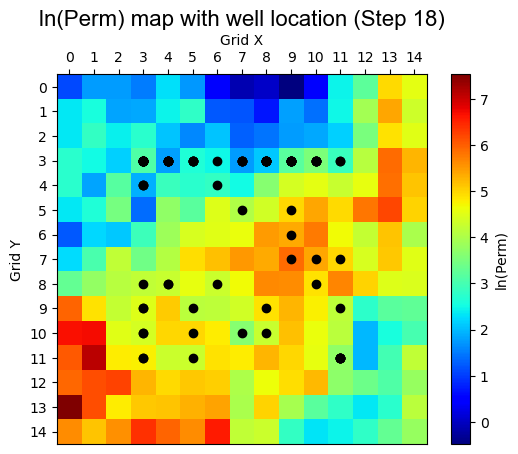

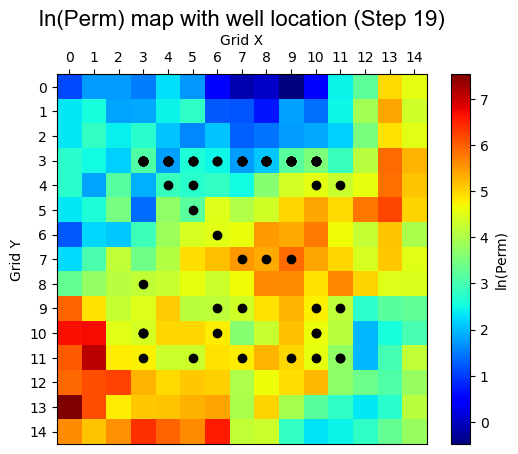

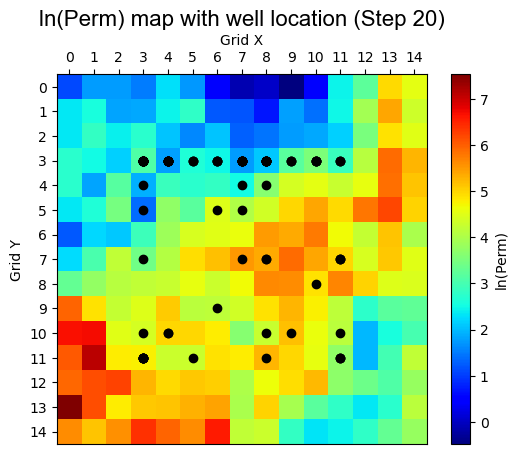

In [30]:
# Read permeability map
perm_field = []

with open(os.path.join(args.basicfilepath, args.perm_filename + ".DATA"), 'r') as file_read:
    lines = file_read.readlines()
    for line_num in range(args.gridnum_x * args.gridnum_y):
        perm_field.append(float(lines[line_num + 1]))

well_placement_dict = {}

for step_num in range(1, args.max_iteration+1):
    for sample_num in range(1, args.sample_num_per_iter+1):
        well_loc_list = []
        # Read Well placement of each sample
        with open(os.path.join(args.simulation_directory, f"Step{step_num}_Sample{sample_num}", f"{args.well_filename}_Sam{sample_num}_Seq{args.total_well_num_max}.DATA")) as file_read:
            line = file_read.readline()
            for time_step in range(0, args.total_well_num_max):
                line = file_read.readline()
                line = file_read.readline()
                line_list = [element.strip() for element in line.split()]
                well_loc = (int(line_list[2]), int(line_list[3]))
                well_loc_list.append(well_loc)
                if time_step == args.total_well_num_max - 1:
                    break
                while not line.startswith("--WELL"):
                    line = file_read.readline()
        # Save Well placement at dictionary [Key: Step{}_Sample{}, Value: list[well_loc -> tuple]]
        well_placement_dict[f'Step{step_num}_Sample{sample_num}'] = well_loc_list


# Draw well placement map at each Step
for step_num in range(1, args.max_iteration+1):
    list_x = []
    list_y = []

    for sample_num in range(1, args.sample_num_per_iter+1):
        for well_location in range(len(well_placement_dict[f'Step{step_num}_Sample{sample_num}'])):
            list_x.append(well_placement_dict[f'Step{step_num}_Sample{sample_num}'][well_location][0]-1) # Grid index: 0~(nx-1)
            list_y.append(well_placement_dict[f'Step{step_num}_Sample{sample_num}'][well_location][1]-1) # Grid index: 0~(ny-1)
    plt.scatter(list_x, list_y, c='k')
    plt.imshow(np.log(np.array(perm_field)).reshape(15,15), cmap='jet')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("ln(Perm)")
    plt.gca().xaxis.tick_top()
    plt.gca().set_xticks(range(0, 15))
    plt.gca().set_xlabel("Grid X", loc='center')
    plt.gca().xaxis.set_label_position('top')
    plt.gca().set_yticks(range(0, 15))
    plt.gca().set_ylabel("Grid Y")
    plt.gca().set_title(f"ln(Perm) map with well location (Step {step_num})", font="Arial", fontsize=16)
    plt.show()

### NPV graph

In [22]:
os.chdir("../")